In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

In [13]:
train_df = pd.read_csv('./datasets/train_data(Sampling완료).csv', encoding="utf-8-sig", index_col=0)
test_df = pd.read_csv('./datasets/test_data(Sampling완료).csv', encoding="utf-8-sig", index_col=0)

In [14]:
X_train = train_df.drop(columns=['이상거래'], axis=1)
y_train = train_df[['이상거래']]

X_test = test_df.drop(columns=['이상거래'], axis=1)
y_test = test_df[['이상거래']]

---
# Standard Scaling

In [15]:
X_train_1 = X_train[['거래량', '카드거래발생거리','실소유자나이','카드거래간시간']]
X_train_concat = X_train.drop(columns=['거래량', '카드거래발생거리','실소유자나이','카드거래간시간'], axis=1)

X_test_1 = X_test[['거래량', '카드거래발생거리','실소유자나이','카드거래간시간']]
X_test_concat = X_test.drop(columns=['거래량', '카드거래발생거리','실소유자나이','카드거래간시간'], axis=1)

In [16]:
X_train_concat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test_concat.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler
# StandardScaler() Scaler객체 생성.
scaler = StandardScaler()
# 학습 데이터에 대해서 fit(), transform() 수행.
scaler.fit(X_train_1)
train_scaled_SS = scaler.transform(X_train_1)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_train_SS = pd.DataFrame(data = train_scaled_SS, columns=X_train_1.columns)

# 테스트 데이터에서는 다시 fit(), transform()이나 fit_transform()을 수행하지 않고 transform만 수행.
test_scaled_SS = scaler.transform(X_test_1)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_test_SS = pd.DataFrame(data = test_scaled_SS, columns=X_test_1.columns)

In [18]:
X_train = pd.concat([X_train_SS, X_train_concat], axis=1)
X_test = pd.concat([X_test_SS, X_test_concat], axis=1)

# feature_selection

In [20]:
## 랜덤포레스트에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 feature_importance 변수 선택
rf = RandomForestClassifier(random_state=1)
param = {
    'max_depth':[2,3,4,5],
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2]
}

grid_rf = GridSearchCV(rf,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_rf.fit(X_train,y_train)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df.iloc[:,4:]

best_rf = grid_rf.best_estimator_  # 최적의 하이퍼파라미터를 적합한 모델
print(best_rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=1,
                       random_state=1)>


### 랜덤포레스트 
### 최적의 하이퍼파라미터{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 1}

거래량                        0.350683
주간                         0.238294
야간                         0.094941
카드거래간시간                    0.052092
하반기                        0.046757
상반기                        0.033026
남성                         0.025689
중서부                        0.025632
남부                         0.024894
여성                         0.021500
소도시                        0.018266
북동부                        0.015359
대도시                        0.013600
서부                         0.009405
category_home              0.004879
중소도시                       0.004736
category_kids_pets         0.004054
category_health_fitness    0.002946
category_misc_pos          0.002699
category_gas_transport     0.001806
category_travel            0.001479
category_grocery_pos       0.001388
category_personal_care     0.001009
category_grocery_net       0.000955
category_food_dining       0.000945
category_shopping_pos      0.000926
category_shopping_net      0.000761
실소유자나이                     0

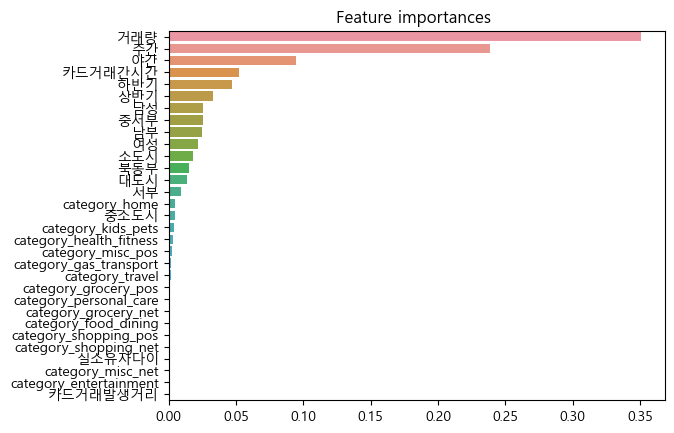

In [21]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'

best_rf.fit(X_train,y_train)
importance= pd.Series(index=X_train.columns,data=best_rf.feature_importances_)
ft_im = importance.sort_values(ascending=False)
print(ft_im)

score = cross_val_score(best_rf, X=X_train, y=y_train, cv=5, scoring='accuracy')
print(f'교차검증 평균 정확도 : {np.mean(score)}')

#plt.figure(figsize=(8,6))
plt.title("Feature importances ")
sns.barplot(x=ft_im,y=ft_im.index)
plt.show()


## 시각화를 통핟여 선정된 피쳐
## ['거래량','야간',주간','카드거래간시간','기타거래','온라인거래','오프라인거래','실소유자나이','하반기','상반기']

In [26]:
## 로지스틱 라쏘규제에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 coefficients를 통하여 변수 선택(0은 설명력 부족한 변수)
lr=LogisticRegression(random_state=1,solver='liblinear')
param = {'C':[0.005,0.01,0.05,0.1,1,2],
         'penalty':['l1','l2']}

grid_lr = GridSearchCV(lr,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_lr.fit(X_train,y_train)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

best_lr = grid_lr.best_estimator_  # 최적의 하이퍼파라미터를 적합한 모델

   param_C param_penalty                         params  split0_test_score  \
0    0.005            l1  {'C': 0.005, 'penalty': 'l1'}           0.849734   
1    0.005            l2  {'C': 0.005, 'penalty': 'l2'}           0.878426   
2     0.01            l1   {'C': 0.01, 'penalty': 'l1'}           0.844452   
3     0.01            l2   {'C': 0.01, 'penalty': 'l2'}           0.868100   
4     0.05            l1   {'C': 0.05, 'penalty': 'l1'}           0.817948   
5     0.05            l2   {'C': 0.05, 'penalty': 'l2'}           0.843167   
6      0.1            l1    {'C': 0.1, 'penalty': 'l1'}           0.810906   
7      0.1            l2    {'C': 0.1, 'penalty': 'l2'}           0.833508   
8        1            l1      {'C': 1, 'penalty': 'l1'}           0.811334   
9        1            l2      {'C': 1, 'penalty': 'l2'}           0.810478   
10       2            l1      {'C': 2, 'penalty': 'l1'}           0.812571   
11       2            l2      {'C': 2, 'penalty': 'l2'}         

In [23]:
best_lr

LogisticRegression(C=2, penalty='l1', random_state=1, solver='liblinear')

거래량                        2.483698
야간                         0.262947
실소유자나이                     0.044730
카드거래발생거리                  -0.003661
카드거래간시간                   -0.243679
category_grocery_pos      -1.047178
category_gas_transport    -1.231712
category_personal_care    -1.391151
category_kids_pets        -1.543881
category_grocery_net      -1.704938
상반기                       -1.719595
category_health_fitness   -1.755029
category_food_dining      -1.787385
category_travel           -1.801387
소도시                       -1.829645
여성                        -1.875359
category_misc_pos         -1.909898
category_home             -1.922468
남성                        -1.956909
주간                        -1.984510
대도시                       -2.027479
중소도시                      -2.046808
category_entertainment    -2.067424
하반기                       -2.203314
category_misc_net         -2.225592
중서부                       -2.689227
남부                        -2.693183
category_shopping_net     -2

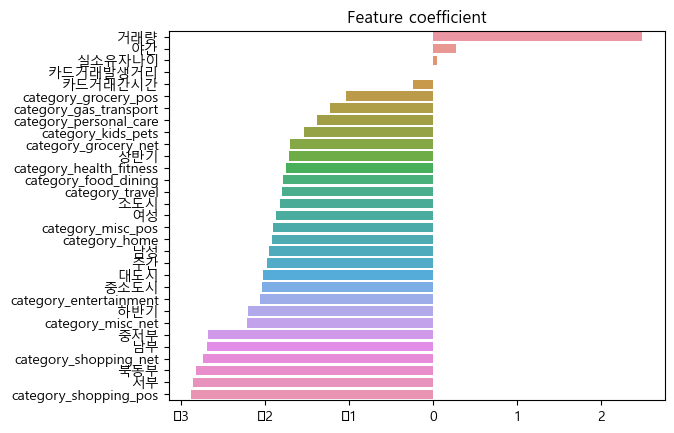

In [27]:
### 로지스틱 라쏘
### 최적의하이퍼파라미터 0.05
la =LogisticRegression(random_state=1,penalty='l2',solver='liblinear',C=0.05)

la.fit(X_train,y_train)
la_col = pd.Series(la.coef_[0],index=X_train.columns).sort_values(ascending=False)
print(la_col)

plt.title("Feature coefficient")
sns.barplot(x=la_col,y=la_col.index)
plt.show()

## 시각화를 통핟여 선정된 피쳐
## ['거래량','야간',주간','카드거래간시간',category,'실소유자나이','하반기','상반기']

- 피쳐 선택결과 유사한 변수선택됨 
- 최종 features selection
- colums = ['거래량', '야간', '실소유자나이', '하반기', '상반기', 주간','카드거래간시간','category',]
- 주간이면 1 야간이면 0인 컬럼
- 하반기면 1 상반기면 0인 컬럼

In [30]:
X_train.columns

Index(['거래량', '카드거래발생거리', '실소유자나이', '카드거래간시간', '중서부', '북동부', '남부', '서부', '상반기',
       '하반기', '주간', '야간', '대도시', '소도시', '중소도시', '남성', '여성',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')

In [34]:
x_selec = X_train[['거래량', '실소유자나이', '중서부', '북동부', '남부', '서부','하반기', '야간', '대도시', '소도시', '중소도시', 
'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness',
'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 
'category_shopping_pos', 'category_travel']]

x_selec.head()

,거래량,실소유자나이,중서부,북동부,남부,서부,하반기,야간,대도시,소도시,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,-0.540868,-0.900411,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.779645,-0.006300,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.649393,2.556819,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.797015,-0.244730,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-0.734202,-1.079234,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_feature(x_train):
    vif = pd.DataFrame()
    vif['VIF_factor'] = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
    vif['feature'] = x_train.columns
    return vif
    
vif =vif_feature(x_selec)
vif